# Electronic Structure Calculations using Generalized Ising Hamiltonians

Your final task is to calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$$ 
H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j
+ \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k
+ \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l
+ \cdots
$$

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided to you by the `read_generalized_ising_hamiltonian` function below.

These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [1]:
import string
import os
import re

import numpy as np

from abstract_ising import AbstractIsing
from ising_animator import IsingAnimator

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [3]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

First, you must write a class that describes the Generalized Ising Model given the arrays containing the Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration (see the previous tasks for inspiration), as well as a function which computes the change in energy resulting from a single-spin-flip (you could of course use the naive approach and simply compute the energy of two spin configurations and subtract one from the other).

In [4]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters

class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, num_spins, coeffs_dct, binary=False):
        """
        Because this is generalised ising it doesn't make any sense to think about dimensionality of spin lattice
        Keep spin lattice as 1d to make indexing simpler. Any concept of dimensionality is baked in with the coefficients
        coeffs is dict containing sets of n-local coefficients
        each key of the dict denotes n
        for example: coeffs[2] is a 2d array of all 2-local coefficients
        """
        assert max(coeffs_dct.keys()) <= 26, f"Yeah... maybe you're asking for too much here"
        for locality, coeffs in coeffs_dct.items():
            if locality >0:
                assert len(coeffs.shape) == locality, f"coefficients for key {locality} should have dimensionality {locality}"
        self.num_spins = num_spins # number of spins
        self.coeffs_dct = coeffs_dct
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1
        self.binary=binary
        
    def energy(self, spins=None):
        spins = self.spins if spins is None else spins
        # Binary mode for energy - Turning energy calc into 0,1 spins
        if ( self.binary ) : spins = (spins+1)/2

        energy = 0
        for locality, coeffs in coeffs_dct.items():
            if locality == 0:
                energy += coeffs
            else:
                ixs = string.ascii_lowercase[:locality]
                subscripts = ixs + ',' + ','.join(ixs)
                operands = [coeffs] + [spins] * locality
                energy += np.einsum(subscripts, *operands)
        #print("En: ",energy, "spins: ", spins)
        return energy
    
    def energy_diff(self, i):
        self.spins[i] *= -1
        next_energy = self.energy()
        self.spins[i] *= -1
        current_energy = self.energy()
        diff = next_energy - current_energy
        return diff
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.num_spins),)

Next you'll run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [5]:
coeffs_dct = {k: v for k, v in enumerate([E0, h, J, K, L])}
ising = GeneralizedIsingModel(4, coeffs_dct)

# perform 1000 MC steps
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=1.0)
    
    if t % 50 == 0:
        print(E)

-0.19222515402425988
-0.40205193171305936
0.5724567781741282
-0.485571076818599
-0.25924181243352884
-0.48557107681859907
-0.333193379859456
-0.485571076818599
-0.333193379859456
-1.1299047752322906
-0.19222515402425988
-0.4020519317130593
-0.485571076818599
-0.333193379859456
-0.33319337985945613
-1.1299047752322906
0.5724567781741281
-0.3331933798594562
-0.40205193171305953
-0.33319337985945613


Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

Minimum energy found by brute force: -1.1299047752322906


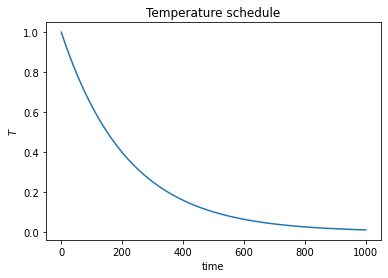

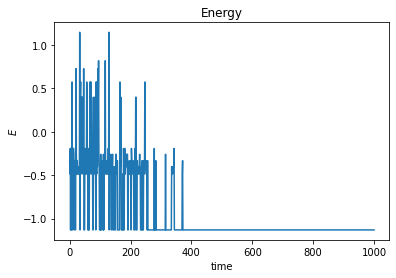

-1.1299047752322906

In [6]:
# BRUTE FORCE CALCULATION
def get_bf_min(ising, return_config=False):
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
    space = 2*space.astype(int) - 1
    energies = []
    for config in space:
        energies.append(ising.energy(config))
    if return_config:
        return min(energies), space[np.argmin(energies)]
    else:
        return min(energies)

def plot_schedule(T):
    t = range(len(T))
    plt.plot(t, T)
    plt.title("Temperature schedule")
    plt.ylabel("$T$")
    plt.xlabel("time");
    plt.show()

# this is for all static annealing schedules
def create_fixed_schedule(num_steps, T_i, T_f=1.0, form='const', cycle={}, show=True):
    """
    we found linear decay is quite useless
    also experimented with adding a exp(sin(t)) multiplier onto the baseline schedule
    """
    implemented = [
        'const', # constant
        'exp', # exponential decay
        'lin', # linear decay
    ]
    assert form in implemented, f"form='{form}' not implemented"
    t = np.arange(num_steps+1)
    if form == 'const':
        T = [T_i] * num_steps
    elif form == 'exp':
        T = T_i * ((T_f/T_i) ** (t/num_steps))
    elif form == 'lin':
        T = T_i + (T_f - T_i) * (t/num_steps)
    if len(cycle):
        amp = cycle['amp']
        period = cycle['p']
        cyc = amp * np.sin(2*np.pi*np.arange(len(T))/period)
        T = T * np.exp(cyc)
    if show:
        plot_schedule(T)
    return T

def plot_energy(Es):
    plt.plot(Es)
    plt.title("Energy")
    plt.ylabel("$E$")
    plt.xlabel("time");
    plt.show()

    
def run_mc(ising, num_steps, T, verbose=False, do_plot=False):
    """
    Runs MC with a static T schedule
    """
    Es = []
    for t in range(num_steps):
        E = ising.mc_step(T=T[t])
        Es.append(E)
        if verbose and t % 100 == 0:
            print(E)
    if do_plot:
        plot_energy(Es)
    if verbose:
        print(f"Minimum energy found by MC: {min(Es)}")
    return min(Es)

bf_min = get_bf_min(ising)
print(f"Minimum energy found by brute force: {bf_min}")
T = create_fixed_schedule(1000, T_i=1, T_f=0.01, form='exp')
run_mc(ising, len(T), T, do_plot=True)

Finally, iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [7]:
# already did this above

Now, clean up your code a little, and write a for-loop that iterates over all the different values of the Hydrogen seperation distance $R$ available in the `hamiltonians` directory. 

For each $R$ you must:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy
- Compare the two results

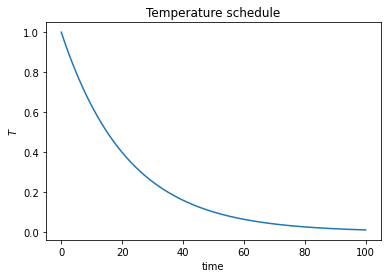

Radii: [0.65, 0.8, 0.95, 1.1, 1.25, 1.4, 1.55, 1.7, 1.85, 2.0, 2.15, 2.3, 2.45, 2.6, 2.75, 2.9, 3.05, 3.2, 3.35, 3.5]


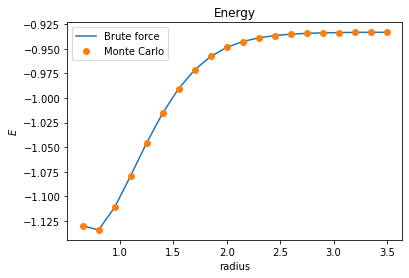

In [8]:
# get ranges from filenames

# T schedule
T = create_fixed_schedule(100, T_i=1, T_f=0.01, form='exp')

Rs = [] # radii
bf_mins = [] # minimum energies found in brute force evaluations
mc_mins = [] # minimum energies found in MC evaluations

for fp in os.listdir('hamiltonians'):
    if 'inp' not in fp:
        continue
    R = re.search('=([0-9,\.]+)\.inp', fp).group(1)
    Rs.append(float(R))
    E0, h, J, K, L = read_generalized_ising_hamiltonian(f"./hamiltonians/Ising-H2-STO-3G-bk-samespin-R={R}.inp")
    coeffs_dct = {k: v for k, v in enumerate([E0, h, J, K, L])}
    ising = GeneralizedIsingModel(4, coeffs_dct)
    bf_mins.append(get_bf_min(ising))
    mc_mins.append(run_mc(ising, len(T), T))

# plotting
bf_mins = [x for _, x in sorted(zip(Rs, bf_mins))]
mc_mins = [x for _, x in sorted(zip(Rs, mc_mins))]
Rs = sorted(Rs)
print(f'Radii: {Rs}')
plt.plot(Rs, bf_mins)
plt.plot(Rs, mc_mins, 'o')
plt.title("Energy")
plt.ylabel("$E$")
plt.xlabel("radius");
plt.legend(['Brute force', 'Monte Carlo'])
plt.show()

## Working with 2-local version

In [9]:
from quantum_H2_ising import GroundStateEnergy

# GroundStateEnergy is a class from Task 1 which, among other things, returns 2-local qubo coefficients
H2 = GroundStateEnergy('H2_coefficients_exact_simulated.csv')
Rs_2 = H2.get_available_R()

[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05, 3.1]


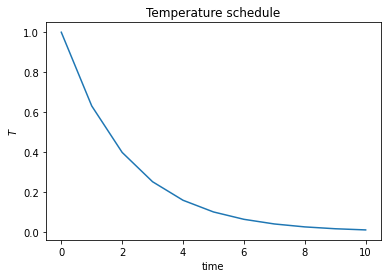

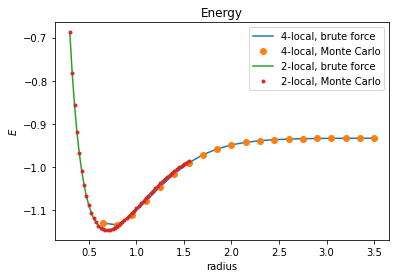

In [10]:
T = create_fixed_schedule(10, T_i=1, T_f=0.01, form='exp')

bf_mins_2 = []
mc_mins_2 = []

for R in Rs_2:
    q_values = H2.get_qubo_coeffs(R)
    # ising coeffs {'a': c_a, 'b': c_a}, {('a', 'b'): c_b}
    h = np.array([q_values['c_a'], q_values['c_a']])
    J = np.array([[0, q_values['c_b']], [0, 0]])
    coeffs_dct = {1: h, 2: J}
    ising = GeneralizedIsingModel(2, coeffs_dct)
    _, bf_min_spins = get_bf_min(ising, return_config=True)
    bf_min = H2.get_energy_from_ising_spins(R, *bf_min_spins)
    bf_mins_2.append(bf_min)
    run_mc(ising, len(T), T)
    mc_mins_2.append(H2.get_energy_from_ising_spins(R, *ising.spins))

# map Rs_2 to half width to match with RsAs
Rs_2 = list(map(lambda x: x/2, Rs_2))
    
# plotting
plt.plot(Rs, bf_mins)
plt.plot(Rs, mc_mins, 'o')
plt.plot(Rs_2, bf_mins_2)
plt.plot(Rs_2, mc_mins_2, '.')
plt.title("Energy")
plt.ylabel("$E$")
plt.xlabel("radius");
plt.legend(['4-local, brute force', '4-local, Monte Carlo', '2-local, brute force', '2-local, Monte Carlo'])
plt.show()

# Challenge 4 - Example for Transportation industry - Operating Crew Routing

We attempt to apply a k-local method to solving a TSP routing problem of k nodes to connect in a specific order and at lowest cost.

Problem: We have 4 route segments to order in 1 or more cycles, at least cost across all cycles. 
Use case: 4 flights requiring pilots. 
          Pilots live at airport A. 
          Order the flight segments in groups (trips) which allow a pilot to start at A and return to A
          Create the optimum number of trips as it translates to minimum number of pilots
          Sequence the flights such that they start where the previous ended (A->B, B->C, C->D, ...)
          
## Source code 

We are reusing our code from the hackathon providing support for loading a flight network and solving on the DWave.
However we only use the code to load the data set that we are interested in benchmarking the Monte Carlo Thermal Anneling on.

In [11]:
from flightHelper import *

Minimum Dep 600
Maximum Arr 1125


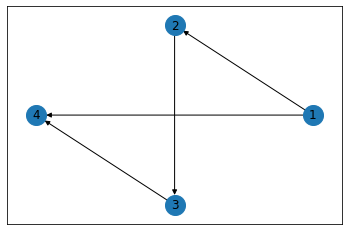

In [12]:
gen = Anneal(dataset="",homebases={ "LCA" : 1 },atypes=[],depday=1)

G1 = gen.buildViewGraph()
pos = nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos, node_size=400 , alpha=1)

In [13]:
# Build the pairwise interactions

connections = np.zeros([gen.getN(),gen.getN()])

for s in gen.segments:
    #print(s.obj.id, end=" ")
    for t in gen.segments:
        if (( t.obj.id > s.obj.id )and (s.obj.arr == t.obj.dep)):
            #print(gap(s.obj,t.obj), end="  ")
            connections[s.obj.id-1,t.obj.id-1] = gap(s.obj,t.obj)
        else:
            #print(0,end="  ")
            connections[s.obj.id-1,t.obj.id-1] = 0

In [14]:
print(connections)

[[  0.  60.   0. 340.]
 [  0.   0.  30.   0.]
 [  0.   0.   0.  65.]
 [  0.   0.   0.   0.]]


## Model and Energy formulation

We create a 4 step by 4 nodes plus one begin state bit (4 x 5 qubits)

This forms a 2D matrix.

Each node qubit index = r * R + n, where R is the number of nodes per row, r is the row (0 to N-1) and n is the node id (0 to N-1)

We also have state qubit index =  r * R + R - 1 indicating if the row r is a start or a continuation in a cycle


Energy = H = HA + HB

    HA = constraints penalty (applies a weight in equivalent minutes)

    HB = cost function (counts numberof minutes)

  


In [15]:
N = gen.getN() # Number of nodes
R = N+1 # Accomodate 1 state bit for each row
W = 10000       # Penalty minutes. We choose 10000 because it is approx 7 days

n_spins = N*R
print("We use", n_spins, "spins")

# Apply a weight when a segment is selected as a start but its not at a home base

E1 = 0.0
HA1 = np.zeros([n_spins,n_spins])
E1 += 1.0
P = W * 2
for r in range(N):
    s = r * R + R - 1
    for n in range(N): # We go up to N. N+1 (R) is for the start bits
        isBase = gen.segments[n].obj.dep in gen.getHomeBases()
        # qubit_s x qubit_n x !isBase x W 
        i = r * N + n
        # In Ising all 0,1 states need to be -1,+1 : Xi = ( Si + 1 ) / 2
        HA1[s,i] = ((not isBase) * P) / 2

#print(len(HA1))
#print(HA1)

# Apply a weight to invalid connection

E2 = 0.0
N2 = N
P = W
HA2h = np.zeros([n_spins])
HA2 = np.zeros([n_spins,n_spins])

for n1 in range(N):
    for n2 in range(N):
        # Not a valid edge: Penalize
        if ((n1!=n2) and (connections[n1,n2]<=0)):
            for r in range(N-1):
                q1 = r * R + n1
                HA2[q1,q1] -= P
                q2 = (r+1) * R + n2
                HA2[q2,q2] -= P
                if ( q1 < q2 ):
                    HA2[q1,q2] += 2 * P 


# Apply a penalty if we have more than 1 selection per row
# Use N2 to represet N so it can be changed

N2 = 1
P = W * 100
E3 = 0.0
HA3h = np.zeros([n_spins])
HA3J = np.zeros([n_spins,n_spins])
E3 += P * ( 1 - 2 * N2 )
for r in range(N):
    for n1 in range(N):
        q1 = r * R + n1
        HA3h[q1] += -P # P * (3 - 4 * N2) 
        for n2 in range(n1+1, N):
            q2 = r * R + n2
            if ( q2>q1 ):
                HA3J[q1,q2] += P * 2 
                
# Apply a penalty if we have more than 1 selection per column             

N2 = 1
P = W * 100
E4 = 0.0
HA4h = np.zeros([n_spins])
HA4J = np.zeros([n_spins,n_spins])
E4 += P * ( 1 - 2 * N2 )
for n1 in range(N):
    for r1 in range(N):
        q1 = r1 * R + n1
        HA4h[q1] += -P # * (3 - 4 * N2) 
        for r2 in range(r1+1, N):
            q2 = r2 * R + n1
            if ( q2>q1 ):
                HA4J[q1,q2] += P * 2

# Apply a penalty if we do not have N qubit selected             

N2 = N
P = W*100
E5 = 0.0
HA5h = np.zeros([n_spins])
HA5J = np.zeros([n_spins,n_spins])

# h = 1 + 2N (N-1)
# J = 2 (for top half triangle)
# E0 = (N(N-1))**2
# Scan the actual N qubit ids
E5 = P * N2**2 # (N2 * ( N2 - 1 )) ** 2
for q in range(N*R):
    if ( ((q+1) % R ) != 0 ):
        HA5h[q] +=  P * (1 - 2 * N2) # ( 1 + 2 * N2 * ( N2-1 ) )
        for q2 in range(q+1,N*R):
            if ( ((q2+1) % R) != 0 ):
                if ( q2>q):
                    HA5J[q,q2] += P * 2 
            
            
# Cost objective function. Add time gaps and CICO times at start of cycles

E6 = 0.0
CICO=90
P = W
HB6h = np.zeros([n_spins])
HB6 = np.zeros([n_spins,n_spins])

# Set the first row start 
HB6h[R-1] = -P * 100000

for r in range(N-1):
    r2 = r + 1
    s1 = r * R + R - 1
    s2 = r2 * R + R - 1
    for n1 in range(N):
        q1 = r * R + n1
        # Penalize segments that do not start at home base
        if ( gen.segments[n1].obj.dep in gen.getHomeBases()):
            HB6h[q1] += -P
        #else:
        #    HB6h[q1] += +P
        
        # Penalize same row items
        for n2 in range(n1+1,N):
            q2 = r * R + n2
            HB6[q1,q2] += 10000 * P
        
        # Add connect connection times
        # If we have a start cycle, remove base penalty 
        for n2 in range(N):
            if (n1!=n2):
                q2 = r2 * R + n2
                if ( q1 < q2 ):
                    HB6[q1,q2] = connections[n1,n2] 
                    HB6[s1,q1] = -P + CICO

# const 7 - Steering step by step
E7 = 0.0
P = W
HB7h = np.zeros([n_spins])
HB7J = np.zeros([n_spins,n_spins])

# Set the first row start 
HB7h[R-1] = -P 

# Prevent same row assignments
for r in range(N):
    #print( "Row ", r)
    for n1 in range(N):
        q1 = r * R + n1
        for n2 in range(N):
            if ( n1!=n2):
                q2 = r * R + n2
                #print("q1,q2 = ", q1, q2)
                HB7J[q1,q2] += P




We use 20 spins


## Discussion about Spins vs Binary

For the purpose of a routing optimizer, using -1/+1 spins for energy calculations did not allow for applying the proper control on the constraints. We added a "binary" option to the energy function which essentially converts the ising spins to binary spins. This has given traction on creating workable constraints.

## Discussion about the constraints

We have been able to incrementally add constraints to steer the quality toward the ultimate goal.
The code comments below explain our method.

The optimizer succeeds at limiting one node per row, each node used only once. 
The next step is to implement the cost function that totals up the wait time between segments and the effect of signaling the start of a new cycle on cost.

We have used up to 2 local variables to describe the constraints. It is not yet clear where using 3 or more would provide additional benefits. 



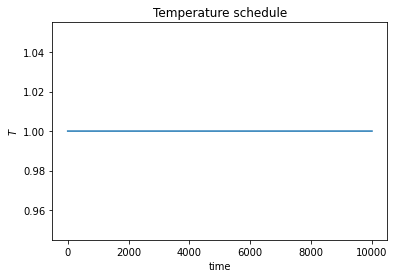

In [16]:
E0 = 0.0
h = np.zeros(n_spins)
J = np.zeros([n_spins,n_spins])
K = np.zeros([n_spins,n_spins,n_spins])
L = np.zeros([n_spins,n_spins,n_spins,n_spins])

# Rebuilding constraints sequence for 0/1 method
# (1) Select exactly 4 nodes - use const 5 
#     Success: We get exactly 4 random segments
# (2) Select exactly 1 node per row - use const 3
#     Success: We get only one selection per row and we continue to only have 4 total
# (3) Select nodes in only one row - use const  4
#     Success: We get 4 nodes, 1 per row and only used once
# (4) Set P for the above 3 constraints from 1 to W
#     FAIL: Result goes bonkers. Leaving P as 1 for now
#     Success: After increasing optim steps to 2000
# (5) Apply W to pairwise non-connectors - const 2
#     FAIL: Weight imbalances. Expand P to W*100 for (1) (2) and (3)
#     Better: Now increase P to W
#     Better: Increase steps
#     FAIL: Unable to get best solution. 
#     Turning of this constraint for best result for discussion (despite shortcomings)


# const 1
#E0 += E1 
#J += HA1

# const 2 - Valid connections
#E0 += E2 
#J += HA2

# const 3 - One per Row

E0 += E3
h += HA3h
J += HA3J

# const 4 - One per column

E0 += E4
h += HA4h
J += HA4J

# const 5 - We want N selections overall

E0 += E5
h += HA5h
J += HA5J

# Objective const 6 - Connect time

#E0 += E6
#h += HB6h
#J += HB6

#h += HB7h
#J += HB7J

steps = 10000
T = create_fixed_schedule(steps, T_i=1, T_f=0.01, form='const')

bf_mins = [] # minimum energies found in brute force evaluations
mc_mins = [] # minimum energies found in MC evaluations

# For reference
# E0, h, J, K, L = read_generalized_ising_hamiltonian(f"./hamiltonians/Ising-H2-STO-3G-bk-samespin-R={R}.inp")

# Adapt this to the transport model


#coeffs_dct = {k: v for k, v in enumerate([E0, h, J, K, L])}
#coeffs_dct = { 0: E0, 1: h, 2 : J, 3 : K, 4: L  }
coeffs_dct = { 0: E0, 1: h, 2 : J }
#coeffs_dct = {  2 : J  }

ising = GeneralizedIsingModel(n_spins, coeffs_dct, binary=True)

bf_mins.append(get_bf_min(ising))
mc_mins.append(run_mc(ising, len(T), T))



In [17]:
print(bf_mins, mc_mins)
print((ising.spins+1)/2)
print("Energy: ", ising.energy())

[-10000000.0] [-10000000.0]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
Energy:  -10000000.0


In [18]:
def segd(id):
    return '{} {}: {}-{}'.format(id,gen.segments[id].obj.lab,gen.segments[id].obj.dep, gen.segments[id].obj.arr)

def spinup(q):
    return ((ising.spins[q]+1)/2 == 1)
    
for r in range(N):
    s = r * R + R - 1
    if spinup(s):
        print("S ", end="")
    else: 
        print(". ", end="")    
    for n in range(N):
        q = r * R + n
        if spinup(q):
            print("    ", segd(n), end=" / ")
    print("")


.      3 X04: ATH-LCA / 
S      1 X02: ATH-LCA / 
.      0 X01: LCA-ATH / 
S      2 X03: LCA-ATH / 
